In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split

In [5]:
CWD = Path.cwd() # This will give the working path, that is the same as the notebook.
# For non interactive scripts (i.e. running script with python), use: CWD = Path(__file__).parent
DATA_PATH = CWD / "../../data/Classification_dataset"
MODELS_PATH = "./models/"
SAMPLE_IMAGE = DATA_PATH / "Anwar Ratool" / "IMG_20210630_102920.jpg"

In [6]:
CHANNELS = 3
WIDTH = 150
HEIGHT = 150
IMAGE_SIZE = (WIDTH,HEIGHT)
IMAGE_SHAPE = (WIDTH,HEIGHT,CHANNELS)
BATCH_SIZE = 32
EPOCHS = 20

In [18]:
def load_image(image_path, target_size=None, show=False):
    image = load_img(str(image_path), target_size=target_size)
    if show:
        display(image)
    return image

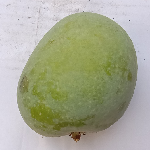

(1, 150, 150, 3)

In [19]:
sample_image = load_image(image_path=SAMPLE_IMAGE, target_size=IMAGE_SIZE, show=True)
sample_image = np.array(sample_image)
sample_image = sample_image.reshape((1, *sample_image.shape))
sample_image.shape

In [20]:
# Function that will create dataframes with path and class columns and will suffle them to generate the folds. These dataframes will be used by ImageDataGenerators

In [21]:
def create_folds (data_path: str, train_split=0.8, val_split=0.75) -> pd.DataFrame:

    classes = [subdir.name for subdir in os.scandir(data_path) if subdir.is_dir()]
    class_dirs = [subdir for subdir in os.scandir(data_path) if subdir.is_dir()]

    all_images = []
    all_classes = []

    for class_dir in class_dirs:
        for file in os.scandir(class_dir.path):
            if file.is_file():
                all_classes.append(class_dir.name)
                all_images.append(file.path)
    df_images = pd.DataFrame({'path': all_images, 'class': all_classes})

    df_full_train, df_test = train_test_split(df_images, train_size=train_split, random_state=1, shuffle=True)
    df_train, df_val = train_test_split(df_full_train, train_size=val_split, random_state=1, shuffle=True)
    print(f'Folds shapes: train={df_train.shape}, val={df_val.shape}, test={df_test.shape}')
    print('Classes = ', classes)
    return df_full_train, df_train, df_val, df_test, classes


Folds shapes: train=(960, 2), val=(320, 2), test=(320, 2)
Classes =  ['Anwar Ratool', 'Chaunsa (Black)', 'Chaunsa (Summer Bahisht)', 'Chaunsa (White)', 'Dosehri', 'Fajri', 'Langra', 'Sindhri']


<AxesSubplot:title={'center':'Train dataset balance'}, ylabel='number of samples'>

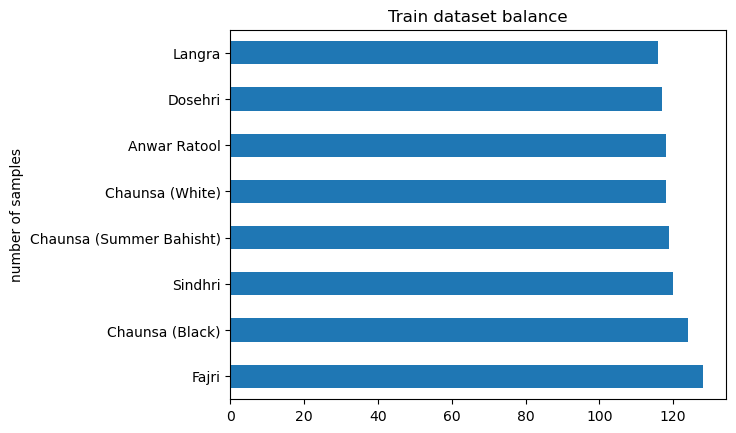

In [22]:
df_full_train, df_train, df_val, df_test, classes = create_folds(DATA_PATH)
df_train['class'].value_counts().plot(kind='barh', title='Train dataset balance', xlabel="number of samples")

In [23]:
number_of_classes = len(classes)

In [24]:
def create_datasets(preprocessing_function, target_size, batch_size, transformations):

    generator_train = ImageDataGenerator(preprocessing_function=preprocessing_function, **transformations)
    generator_val = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_dataset = generator_train.flow_from_dataframe(
        df_train,
        x_col = 'path',
        y_col = 'class',
        target_size = target_size, 
        class_mode = 'categorical',
        batch_size = batch_size, 
    )
    val_dataset = generator_val.flow_from_dataframe(
        df_val,
        x_col = 'path',
        y_col = 'class',
        target_size = target_size, 
        class_mode = 'categorical', 
        batch_size = batch_size, 
        shuffle = False
    )
    test_dataset = generator_val.flow_from_dataframe(
        df_val,
        x_col = 'path',
        y_col = 'class',
        target_size = target_size, 
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle = False
    )

    return train_dataset, val_dataset, test_dataset


In [25]:
train_dataset, val_dataset, test_dataset = create_datasets(preprocessing_function=preprocess_input, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, transformations={})

Found 960 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


In [26]:
print(f'Classes index = {train_dataset.class_indices}')

Classes index = {'Anwar Ratool': 0, 'Chaunsa (Black)': 1, 'Chaunsa (Summer Bahisht)': 2, 'Chaunsa (White)': 3, 'Dosehri': 4, 'Fajri': 5, 'Langra': 6, 'Sindhri': 7}


In [27]:
def plot_history(history, label=None):
  epochs = len(history.history['accuracy'])
  plt.plot(history.history['accuracy'], label=f'train:{label}')
  plt.plot(history.history['val_accuracy'], label=f'val:{label}')
  plt.xticks(np.arange(epochs))
  plt.legend()

def plot_scores(scores, ax=None):
  fig, ax = plt.subplots(1,2, figsize=(10,4))
  for param, history in scores.items():
    epochs = len(history.history['accuracy'])
    ax[0].plot(history.history['accuracy'], label=f'train: {param}')
    ax[1].plot(history.history['val_accuracy'], label=f'val :{param}')
    ax[0].set_xticks(np.arange(epochs))
    ax[1].set_xticks(np.arange(epochs))
    ax[0].set_yticks(np.arange(0,1.05,0.05))
    ax[1].set_yticks(np.arange(0,1.05,0.05))

  ax[0].legend()
  ax[1].legend()

By default, we will use batch normalization. Batch normalization is a technique for training neural networks that normalizes the contributions to a layer for every mini-batch. This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train neural networks.  
We use polling average in Xception model
https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739

In [28]:
def make_model(input_shape=IMAGE_SHAPE, number_of_classes=None, learning_rate=0.01, inner_layers=None):
      
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)

    x = keras.layers.BatchNormalization()(x)
    
    if inner_layers and len(inner_layers) > 0:
        for layer in inner_layers:
            print(layer)
            for param, value in layer.items():
                if param == 'size':
                    x = keras.layers.Dense(units=value, activation='relu')(x)
                if param == 'drop_rate':
                    x = keras.layers.Dropout(value, seed=1)(x)

    outputs = keras.layers.Dense(units=number_of_classes, activation='softmax')(x)  # Softmax activationb, check https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)  # We use softmax in the output layer
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    print(model.summary())

    return model

In [29]:
def create_checkpoint(name:str='xception-v1', path=MODELS_PATH, delete_files=True)->keras.callbacks.ModelCheckpoint: 

    if delete_files:
        for file in os.listdir(path):
            if name in file:
                os.remove(f'{path}{file}')

    return keras.callbacks.ModelCheckpoint(
        f'{path}{name}' + '.{epoch:02d}_{val_accuracy:.3f}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

In [30]:
def run_train(checkpoint=None, inner_layers_tests=[[]], epochs=20, learning_rates=[], input_shape=(150,150,3)):
    
    scores = {}
    for learning_rate in learning_rates:
        for inner_layers in inner_layers_tests:
            model = make_model(input_shape=input_shape, number_of_classes=number_of_classes, learning_rate=learning_rate, inner_layers=inner_layers)
            history = model.fit(x=train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[checkpoint])
            params = f'lr={learning_rate}' + '-'.join([f'{param}={value}' for layer in inner_layers for param, value in layer.items()])
            scores[params]=history
    return scores, model

A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time. They are reflected in the training time loss but not in the test time loss.

Besides, the training loss that Keras displays is the average of the losses for each batch of training data, over the current epoch. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. This can bring the epoch-wise average down. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

## Learning rate selection
Let's check which learning rate gives the best validation accuracy

In [17]:
checkpoint = create_checkpoint('xception-v1')

In [18]:
learning_rates = np.logspace(-3,-1,3)
scores, model = run_train(checkpoint, inner_layers_tests=[[]], epochs=EPOCHS, learning_rates=learning_rates, input_shape=IMAGE_SHAPE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 20,886,064
Trainable params: 20,488
Non-trainable params: 20,865,576
_________________________________________________________________
None
Epoch 1/20
30/30 [==============================] - 28s 553ms/step - loss: 1.0434 - accuracy: 0.6458 - va

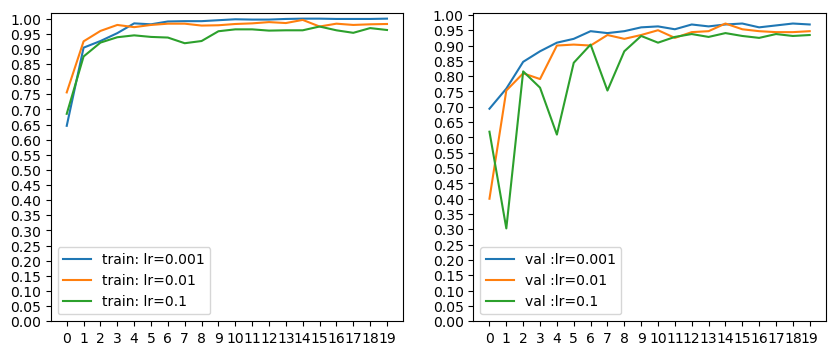

In [19]:
plot_scores(scores)

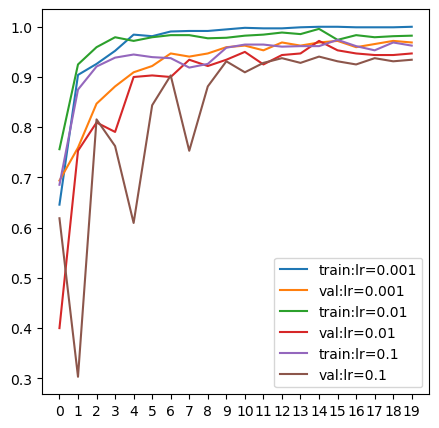

In [20]:
fig = plt.figure(figsize=(5,5))
for lr, history in scores.items():
    plot_history(history, lr)

Best lr = 0.01

In [49]:
learning_rate=0.01

## Add inner dense layers

In [22]:
checkpoint = create_checkpoint('xception-v2')

In [23]:
learning_rates = [learning_rate]
inner_layers_tests = [[{'size': 10}], [{'size': 100}], [{'size': 1000}]]
scores, model = run_train(checkpoint, inner_layers_tests, epochs=EPOCHS, learning_rates=learning_rates, input_shape=IMAGE_SHAPE)

{'size': 10}
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_19 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
Total params: 20,890,250
Trainable params: 24,674
Non-trainable params: 20,865,576
_____________________________

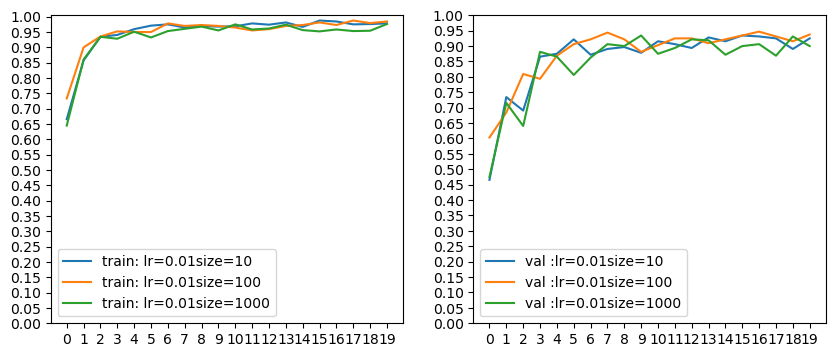

In [24]:
plot_scores(scores)

Adding an inner layer will not improve the validation accuracy. In any case, inner layer with 100 units is the best one. Let's use it for regularization

## Add drop-out regularization

In [26]:
checkpoint = create_checkpoint('xception-v3')

When we add drop-out, more epochs may be needed, since the nn will not always "update" the coefficients. 
More difficult for the net to fit the data. Less overfitting is expected (i.e. overfits later on)
Whe using data augmentation, there are more images, so more epochs will be needed. Similar to the case when we add drop-out. 

In [27]:
inner_layers_tests = [
  [{'size': 100, 'drop_rate': 0.0}], 
  [{'size': 100, 'drop_rate': 0.2}], 
  [{'size': 100, 'drop_rate': 0.5}], 
  #[{'size': 100, 'drop_rate': 0.8}]
]
scores, model = run_train(checkpoint, inner_layers_tests, epochs = 2 * EPOCHS, learning_rates=[learning_rate], input_shape=IMAGE_SHAPE)

{'size': 1000, 'drop_rate': 0.0}
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_34 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 1000)              2049000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 8008      
                          

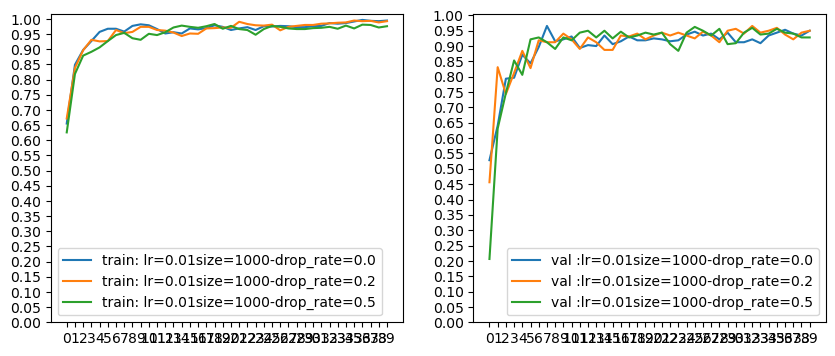

In [28]:
plot_scores(scores)

Drop rate = 0.5 will give a decent val score while not overfitting.

In [45]:
inner_layers_tests = [
  [{'size': 100, 'drop_rate': 0.5}]
]

## Data augmentation
By checking the images, it seems that the mangoes are placed differently on the horizontal axis, so horizontal flip may be recommended.
Whe using data augmentation, there are more images, so more epochs will be needed. Similar to the case when we add drop-out. More difficult for the net to fit the data. Less overfitting is expected (i.e. overfits later)

In [30]:
checkpoint = create_checkpoint('xception-v4')

In [16]:
transformations = transformations={'horizontal_flip':True}
train_dataset, val_dataset, test_dataset = create_datasets(preprocessing_function=preprocess_input, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, transformations=transformations)

NameError: name 'create_datasets' is not defined

In [32]:
scores, model = run_train(checkpoint, inner_layers_tests, epochs = 2 * EPOCHS, learning_rates=[learning_rate], input_shape=IMAGE_SHAPE)

{'size': 1000, 'drop_rate': 0.5}
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_49 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 1000)              2049000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 8)                 8008      
                          

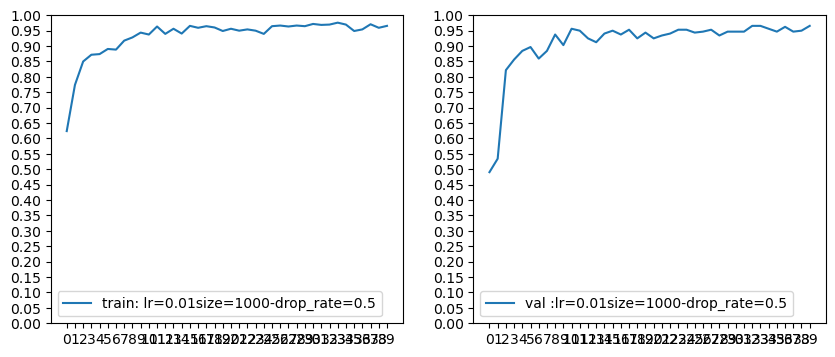

In [33]:
plot_scores(scores)

## Train large image

In [46]:
CHANNELS = 3
WIDTH = 299
HEIGHT = 299
IMAGE_SIZE = (WIDTH,HEIGHT)
IMAGE_SHAPE = (WIDTH,HEIGHT,CHANNELS)

In [47]:
checkpoint = create_checkpoint('best-model')

In [50]:
train_dataset, val_dataset, test_dataset = create_datasets(preprocessing_function=preprocess_input, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, transformations=transformations)
scores, model = run_train(checkpoint, inner_layers_tests, epochs = 2 * EPOCHS, learning_rates=[learning_rate], input_shape=IMAGE_SHAPE)

Found 960 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.
{'size': 100, 'drop_rate': 0.5}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)       

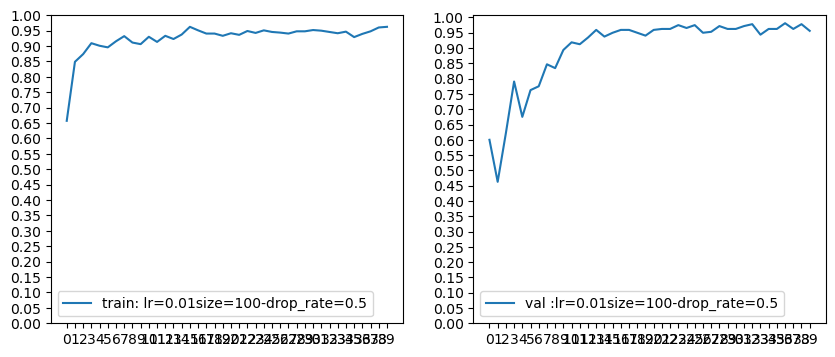

In [51]:
plot_scores(scores)

Test with 80 10 10  

Test with efficienteNet

## Test model

In [55]:
# Evaluate the best model on the test dataset

In [14]:
BEST_MODEL = 'best-model.36_0.975.h5'
model = keras.models.load_model(MODELS_PATH + BEST_MODEL)

In [40]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy = {test_accuracy:0.4f}')

10/10 [==============================] - 3s 277ms/step - loss: 0.1407 - accuracy: 0.9750
Test accuracy = 0.9750


The performance is good enough to push it to production

In [219]:
# Test a single image

In [140]:
SAMPLE_IMAGE = DATA_PATH / "Dosehri" / "IMG_20210629_182957.jpg"
#SAMPLE_IMAGE = DATA_PATH / "Anwar Ratool" / "IMG_20210630_102920.jpg"
#SAMPLE_IMAGE = DATA_PATH / "Anwar Ratool" / "IMG_20210630_104117.jpg"
IMAGE_SIZE = (299,299)

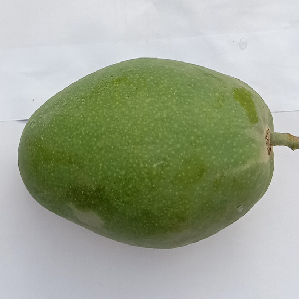

1/1 [==============================] - 0s 222ms/step
{'Anwar Ratool': 3.3505832e-34, 'Chaunsa (Black)': 0.089406766, 'Chaunsa (Summer Bahisht)': 0.0, 'Chaunsa (White)': 0.0, 'Dosehri': 0.9105932, 'Fajri': 1.2549421e-28, 'Langra': 1.4755884e-22, 'Sindhri': 6.9475325e-26}


numpy.ndarray

In [158]:
image = load_image(SAMPLE_IMAGE, IMAGE_SIZE, show=True)
x = preprocess_input(np.array(image))
X = np.expand_dims(x,axis=0)
preds = model.predict(X)
print(dict(zip(classes, preds[0,:])))
type(preds[0,:])

In [54]:
# Test a sample image from the test dataset

In [242]:
index = np.random.randint(0, BATCH_SIZE+1)
sample = next(test_dataset)
train_img = sample[0][index]
y = sample[1][index]
X = np.expand_dims(train_img, axis=0)
preds = model.predict(X)
pd.DataFrame({'class': classes, 'y':y, 'preds': np.round(preds[0],8), 'diff': np.round(np.abs(y - preds[0]), 5)})


1/1 [==============================] - 0s 50ms/step


,class,y,preds,diff
0,Anwar Ratool,0.0,0.0,0.0
1,Chaunsa (Black),0.0,0.0,0.0
2,Chaunsa (Summer Bahisht),0.0,0.0,0.0
3,Chaunsa (White),1.0,1.0,0.0
4,Dosehri,0.0,0.0,0.0
5,Fajri,0.0,0.0,0.0
6,Langra,0.0,0.0,0.0
7,Sindhri,0.0,0.0,0.0


In [246]:
# Note: To get the class of the highest prediction:
np.array(classes)[np.argmax(preds,1)]


array(['Chaunsa (White)'], dtype='<U24')